# Throughputs and dollar-normalized throughputs across training jobs

In this notebook, we plot a bar graph showing the relative throughputs and dollar-normalized throughputs for different models across accelerator types.

In [1]:
import json
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

## Parse oracle_throughputs.json file

In [2]:
throughputs_file = 'oracle_throughputs.json'
with open(throughputs_file, 'r') as f:
    throughputs = json.load(f)

In [3]:
isolated_throughputs = {}
models = []
for worker_type in throughputs:
    isolated_throughputs[worker_type] = {}
    for model in throughputs[worker_type]:
        models.append(model)
        isolated_throughputs[worker_type][model] = \
            throughputs[worker_type][model]['null']
models = sorted(list(set(models)))
worker_types = ['k80', 'p100', 'v100']
on_demand_prices = {
    'k80': 0.52,
    'p100': 1.68,
    'v100': 2.85,
}

## Plot throughputs and dollar-normalized throughputs (using GCP on-demand prices)

In [4]:
def plot_throughputs(models, model_mapping, label_mapping,
                     normalized=False, output_filename=None):
    plt.figure(figsize=(12, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.1f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        size=20, rotation=45)
    
    offset = 0
    for worker_id, worker_type in enumerate(worker_types):
        row = [isolated_throughputs[worker_type][model] /
               isolated_throughputs['k80'][model]
               for model in models]
        if normalized:
            row = [(x * on_demand_prices['k80']) /
                   on_demand_prices[worker_type] for x in row]
        offsets = [(1.2 * i * len(worker_types)) + offset for i in range(len(row))]
        rects = ax.bar(offsets, row, label=label_mapping[worker_type])
        autolabel(rects)
        offset += 0.8

    if normalized:
        ax.set_ylabel("Dollar-normalized\nThpt. (w.r.t. K80)")
        ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6])
    else:
        ax.set_ylabel("Throughput\n(w.r.t. K80)")
        ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_ylim([0, None])
    ax.set_xticks([(1.2 * i * len(worker_types)) + (offset / 2) - 0.4 for i in range(len(row))])
    models = [model_mapping[model] if model in model_mapping else model for model in models]
    ax.set_xticklabels(models)
    sns.despine()
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    leg = plt.figlegend(loc='upper center', ncol=3,
                        frameon=False, labelspacing=0.25,
                        columnspacing=0.8, handlelength=1.5,
                        handletextpad=0.4)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    yOffset = 0.2
    xOffset = 0.0
    bb.y0 += yOffset
    bb.y1 += yOffset
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
        
    plt.show()

/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


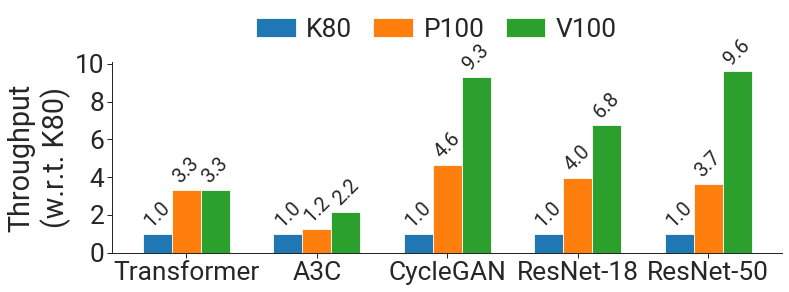

/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


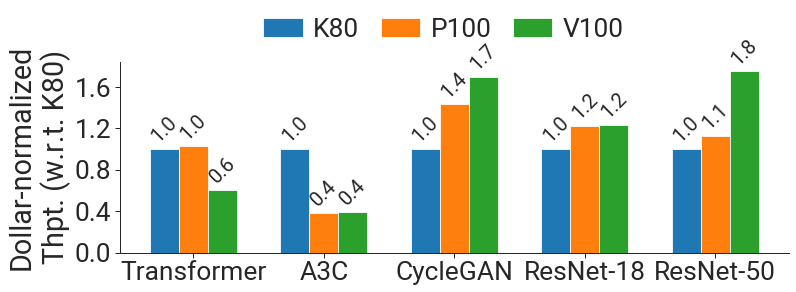

In [5]:
model_mapping = {
    'ResNet-18 (batch size 256)': 'ResNet-18',
    'ResNet-50 (batch size 128)': 'ResNet-50',
    'Transformer (batch size 256)': 'Transformer',
}
label_mapping = {
    'k80': 'K80',
    'p100': 'P100',
    'v100': 'V100',
}
plot_throughputs(models=['Transformer (batch size 256)',
                         'A3C', 'CycleGAN',
                         'ResNet-18 (batch size 256)',
                         'ResNet-50 (batch size 128)'],
                 model_mapping=model_mapping,
                 label_mapping=label_mapping,
                 output_filename="throughput.pdf")
plot_throughputs(models=['Transformer (batch size 256)',
                         'A3C',
                         'CycleGAN',
                         'ResNet-18 (batch size 256)',
                         'ResNet-50 (batch size 128)'],
                 model_mapping=model_mapping,
                 label_mapping=label_mapping,
                 normalized=True,
                 output_filename="normalized_throughput_per_cost.pdf")